In [1]:
import os
import plaid
import requests
from iexfinance.stocks import get_historical_data
from iexfinance.refdata import get_symbols
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

Using the iedfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
from iexfinance.stocks import get_historical_data
import iexfinance as iex

# Data Collection

Using the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [7]:
tickers=pd.DataFrame(get_symbols())
tickers = ["SPY", "AGG"]

# Setting start and end datetimes of 3 years, between now and 1095 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-1095)

# Getting 3 year's worth of historical data
df = get_historical_data(tickers, start_date, end_date,  output_format='pandas')
df.head()

SPY                                        AGG                  \
              open    high     low   close     volume    open    high     low   
date                                                                            
2016-09-19  214.13  214.88  213.03  213.41   80250490  111.73  111.85  111.69   
2016-09-20  214.41  214.59  213.38  213.42   69665279  111.90  111.94  111.74   
2016-09-21  214.24  216.03  213.44  215.82  110284425  111.69  112.03  111.65   
2016-09-22  217.00  217.53  216.71  217.18   76678713  112.10  112.35  112.10   
2016-09-23  216.72  216.88  215.88  215.99   73630921  112.31  112.35  112.21   

                             
             close   volume  
date                         
2016-09-19  111.71  2026930  
2016-09-20  111.75  2078533  
2016-09-21  112.03  1899475  
2016-09-22  112.26  2017170  
2016-09-23  112.23  3415707

In [8]:
# Dropping Extraneous Columns 
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head()

,SPY,AGG
,close,close
date,,
2016-09-19,213.41,111.71
2016-09-20,213.42,111.75
2016-09-21,215.82,112.03
2016-09-22,217.18,112.26
2016-09-23,215.99,112.23


### Calculate Daily Returns

In [10]:
daily_returns = df.pct_change()
daily_returns.head()

,SPY,AGG
,close,close
date,,
2016-09-19,NaN,NaN
2016-09-20,0.000047,0.000358
2016-09-21,0.011245,0.002506
2016-09-22,0.006302,0.002053
2016-09-23,-0.005479,-0.000267


# Monte Carlo Simulation

Running Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

With the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 100 iterations and generate at least 20 years of closing prices

In [11]:
# Calculate the daily roi for the stocks
avg_daily_return_spy = daily_returns.mean()['SPY']['close']
avg_daily_return_agg = daily_returns.mean()['AGG']['close']
avg_daily_return_agg


7.864725590570772e-06

In [12]:
# Calculate volatility
std_dev_daily_return_spy = daily_returns.std()['SPY']['close']
std_dev_daily_return_agg = daily_returns.std()['AGG']['close']
std_dev_daily_return_agg

0.001906410649238661

In [16]:
# Save the last day's closing price
spy_last_price = df['SPY']['close'][-1]
agg_last_price = df['AGG']['close'][-1]

In [17]:
# Setup the Monte Carlo Parameters
num_simulations = 100
num_trading_days = 252 * 30
monte_carlo = pd.DataFrame()

In [19]:
# Run the Monte Carlo Simulation
    
    # Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `100` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of `SPY` and `AGG`
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    
    # Simulate the returns for 7560 days
    for i in range(num_trading_days):
        
        # Calculate the simulated price using the last price within the list
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        
        # Append the simulated price to the list
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_price_df["AGG prices"] = pd.Series(simulated_agg_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.tail()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
7556,10.909797,5.961223,20.056751,7.843838,6.733245,13.581770,7.899493,7.584343,5.971492,13.368875,...,9.756560,14.529306,7.615684,6.021352,22.573186,7.215034,7.606944,11.399724,6.642887,6.362869
7557,10.843661,5.956457,20.106659,7.859006,6.755895,13.504075,7.920100,7.542728,6.002461,13.450275,...,9.795173,14.660958,7.654919,5.991936,22.462435,7.202846,7.623458,11.429799,6.669444,6.370484
7558,10.827201,6.007798,20.260607,7.898565,6.786637,13.490810,7.977110,7.519526,6.030585,13.399582,...,9.798482,14.747145,7.701219,5.983582,22.307731,7.216467,7.656236,11.295993,6.602125,6.360458
7559,10.831874,5.978449,20.260832,7.876490,6.792199,13.484651,8.047763,7.517831,6.063162,13.379180,...,9.765016,14.767989,7.687243,6.013615,22.357482,7.222124,7.662585,11.338455,6.540275,6.376714
7560,10.896255,6.011673,20.238817,7.894484,6.802722,13.379638,8.015196,7.423753,5.996385,13.354008,...,9.743182,14.795167,7.649336,6.047533,22.338761,7.210181,7.674953,11.359784,6.520668,6.373382


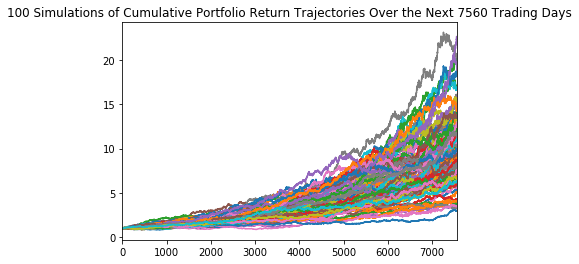

In [20]:
# Visualize the Simulation
plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next {num_trading_days} Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [21]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    10.896255
1     6.011673
2    20.238817
3     7.894484
4     6.802722
Name: 7560, dtype: float64

In [22]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns_20years = portfolio_cumulative_returns.iloc[-2520, :]
ending_cumulative_returns_20years.head()

0    5.630762
1    3.339683
2    6.444279
3    3.776049
4    5.550974
Name: 5041, dtype: float64

In [24]:
# Display the 90% confidence interval for the ending returns
confidence_interval_30_years = ending_cumulative_returns.quantile(q=[0.1, 0.9])
confidence_interval_30_years

0.1     5.411587
0.9    14.868650
Name: 7560, dtype: float64

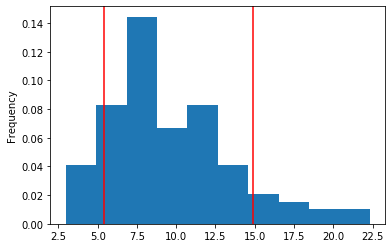

In [27]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval_30_years.iloc[0], color='r')
plt.axvline(confidence_interval_30_years.iloc[1], color='r')

---

# Retirement Analysis

Using the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [32]:
confidence_interval= ending_cumulative_returns.quantile(q=[0.1, 0.5, 0.9])
confidence_interval

0.1     5.411587
0.5     8.618179
0.9    14.868650
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [33]:
# Set initial investment
initial_investment = 20000

# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = initial_investment + (initial_investment * confidence_interval.iloc[0])
investment_pnl_middle_bound = initial_investment + (initial_investment * confidence_interval.iloc[1])
investment_pnl_upper_bound = initial_investment + (initial_investment * confidence_interval.iloc[2])
                                                    
# Print the results
print(f"There is a 90% chance that an initial investment of $20,000 in the portfolio"
      f" over the next 30 years will end at around"
      f" ${investment_pnl_lower_bound}, 50% chance that will end at ${investment_pnl_middle_bound} and 10% chance that will end at around ${investment_pnl_upper_bound}")

There is a 90% chance that an initial investment of $20,000 in the portfolio over the next 30 years will end at around $128231.74490684853, 50% chance that will end at $192363.5832185201 and 10% chance that will end at around $317372.99173165316


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [38]:
retiree_income_90percentile = investment_pnl_lower_bound*.04
print(f"The 4% withdrawal rate of the 90 percentil expected return is ${retiree_income_90percentile}. This amount is lower than the current annual income")

The 4% withdrawal rate of the 90 percentil expected return is $5129.269796273941. This amount is lower than the current annual income


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [41]:
retiree_income_50percentile = investment_pnl_middle_bound*.04
print(f"The 4% withdrawal rate of the 50 percentil expected return is ${retiree_income_50percentile}. This amount is closer to the current annual income")

The 4% withdrawal rate of the 50 percentil expected return is $7694.543328740804. This amount is closer to the current annual income


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# YOUR CODE HERE